# 1. Base Model
---

In this notebook, we will prepare dataset and build a base model.

## Import Libraries

In [1]:
from keras import preprocessing, Input, Model, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sys
sys.path.append("../src")
from utils import destination, show_images

Using TensorFlow backend.


## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None,skip_blank_lines=False).fillna("")

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,sea instapic instagram trip travel
1,sea_image_1284.jpg,sea
2,sea_image_1122.jpg,sea love
3,sea_image_1679.jpg,beach sea trip island japan
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...


In [3]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

print(f"Number of images: {num_images}")
print(f"Number of hashtags: {num_hashtags}")

Number of images: 57383
Number of hashtags: 997


## Prepare Images

In [4]:
IMAGE_DIR = "../HARRISON/images"

# Instanciate a data generator
datagen = ImageDataGenerator(rescale=1./255.)

# Use these values to split data into train, val, and test
train_idx = int(target.shape[0] * .70)
val_idx = int(target.shape[0] * .90)

# Create train data generator
train_generator = datagen.flow_from_dataframe(
        dataframe=target[:train_idx],
        directory=IMAGE_DIR,
        x_col="filename",
        y_col=columns,
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(100,100)
    )

# Create val data generator
valid_generator = datagen.flow_from_dataframe(
        dataframe=target[train_idx:val_idx],
        directory=IMAGE_DIR,
        x_col="filename",
        y_col=columns,
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(100,100)
    )

# Create test data generator
test_generator = datagen.flow_from_dataframe(
        dataframe=target[val_idx:],
        directory=IMAGE_DIR,
        x_col="filename",
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(100,100)
    )

Found 40168 validated image filenames.
Found 11476 validated image filenames.
Found 5739 validated image filenames.


## Build a Model
### 1. Multiple Output Nodes

In [5]:
# Define model
inp = Input(shape=(100,100,3))
x = Conv2D(32, (3, 3), padding='same')(inp)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
output = []
for i in range(num_hashtags):
    output.append(Dense(1, activation='sigmoid')(x))

model = Model(inp,output)

# Compile model
model.compile(optimizers.rmsprop(
    lr=0.0001,
    decay=1e-6),
    loss = ["binary_crossentropy" for i in range(num_hashtags)],
    metrics=["accuracy"])

## Fitting the Model

In [6]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(num_hashtags)])

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=generator_wrapper(train_generator),
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=generator_wrapper(valid_generator),
    validation_steps=STEP_SIZE_VALID,
    epochs=1,
    verbose=0)

In [7]:
# Save model for future use
dest = os.path.join("..", "model")
model.save(destination(dest, "keras_model_oversampled"))

## Prediction

In [16]:
# Load model
model = load_model("../model/1031004017_keras_model")

In [21]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

5739/5739 [==============================] - 234s 41ms/step


In [42]:
def get_conf(row: list) -> dict:
    # Get hashtags with confidence
    keys = np.array(columns)[np.argwhere(row>0).flatten()]
    values = row[np.where(row>0)]
    
    # Sort the result 
    idx = values.argsort()[::-1]
    values = values[idx]
    keys = keys[idx]
    dict(zip(keys, values))

    return dict(zip(keys, values))

In [52]:
# Zscore normalization
pred_reshaped = np.array(pred).reshape((num_hashtags, num_images-val_idx)).transpose()
normalized = (pred_reshaped - pred_reshaped.mean())/pred_reshaped.std()
abv3std = np.where(normalized>3, normalized, 0)

# Get lists of hashtags
y_pred = pd.concat([
    pd.Series(test_generator.filenames, name="filename"),
    pd.Series([get_conf(row) for row in abv3std], name="y_pred")],
    axis=1)

results = target[["filename", "labels"]][val_idx:]
results.rename(columns={"labels": 'y_true'}, inplace=True)
results.index = y_pred.index
results["y_pred"] = pd.Series([list(row.keys()) for row in y_pred.y_pred], name="y_pred")
results.head()

,filename,y_true,y_pred
0,justinbieber_image_1127.jpg,likeme follow onedirection harrystyles arianag...,"[love, friend, family, girl, fashion, yellow, ..."
1,makeup_image_696.jpg,makeup,"[love, friend, family, yellow, girl, nike, hap..."
2,truth_image_2843.jpg,word wisdom truth quote,"[love, yellow, friend, fashion, family, girl, ..."
3,dog_image_1067.jpg,bff cloud dog bestfriends dogsofinstagram,"[love, friend, family, girl, fashion, beach, n..."
4,family_image_2692.jpg,kid boy child park april outdoors family likes...,"[love, friend, family, bored, nike, girl, blac..."


## Prediction Results

In [7]:
results = pd.read_csv("temp", names=["filename","y_true","y_pred"])
results["y_pred"] = results["y_pred"].apply(lambda x: x.split("'")[1::2])


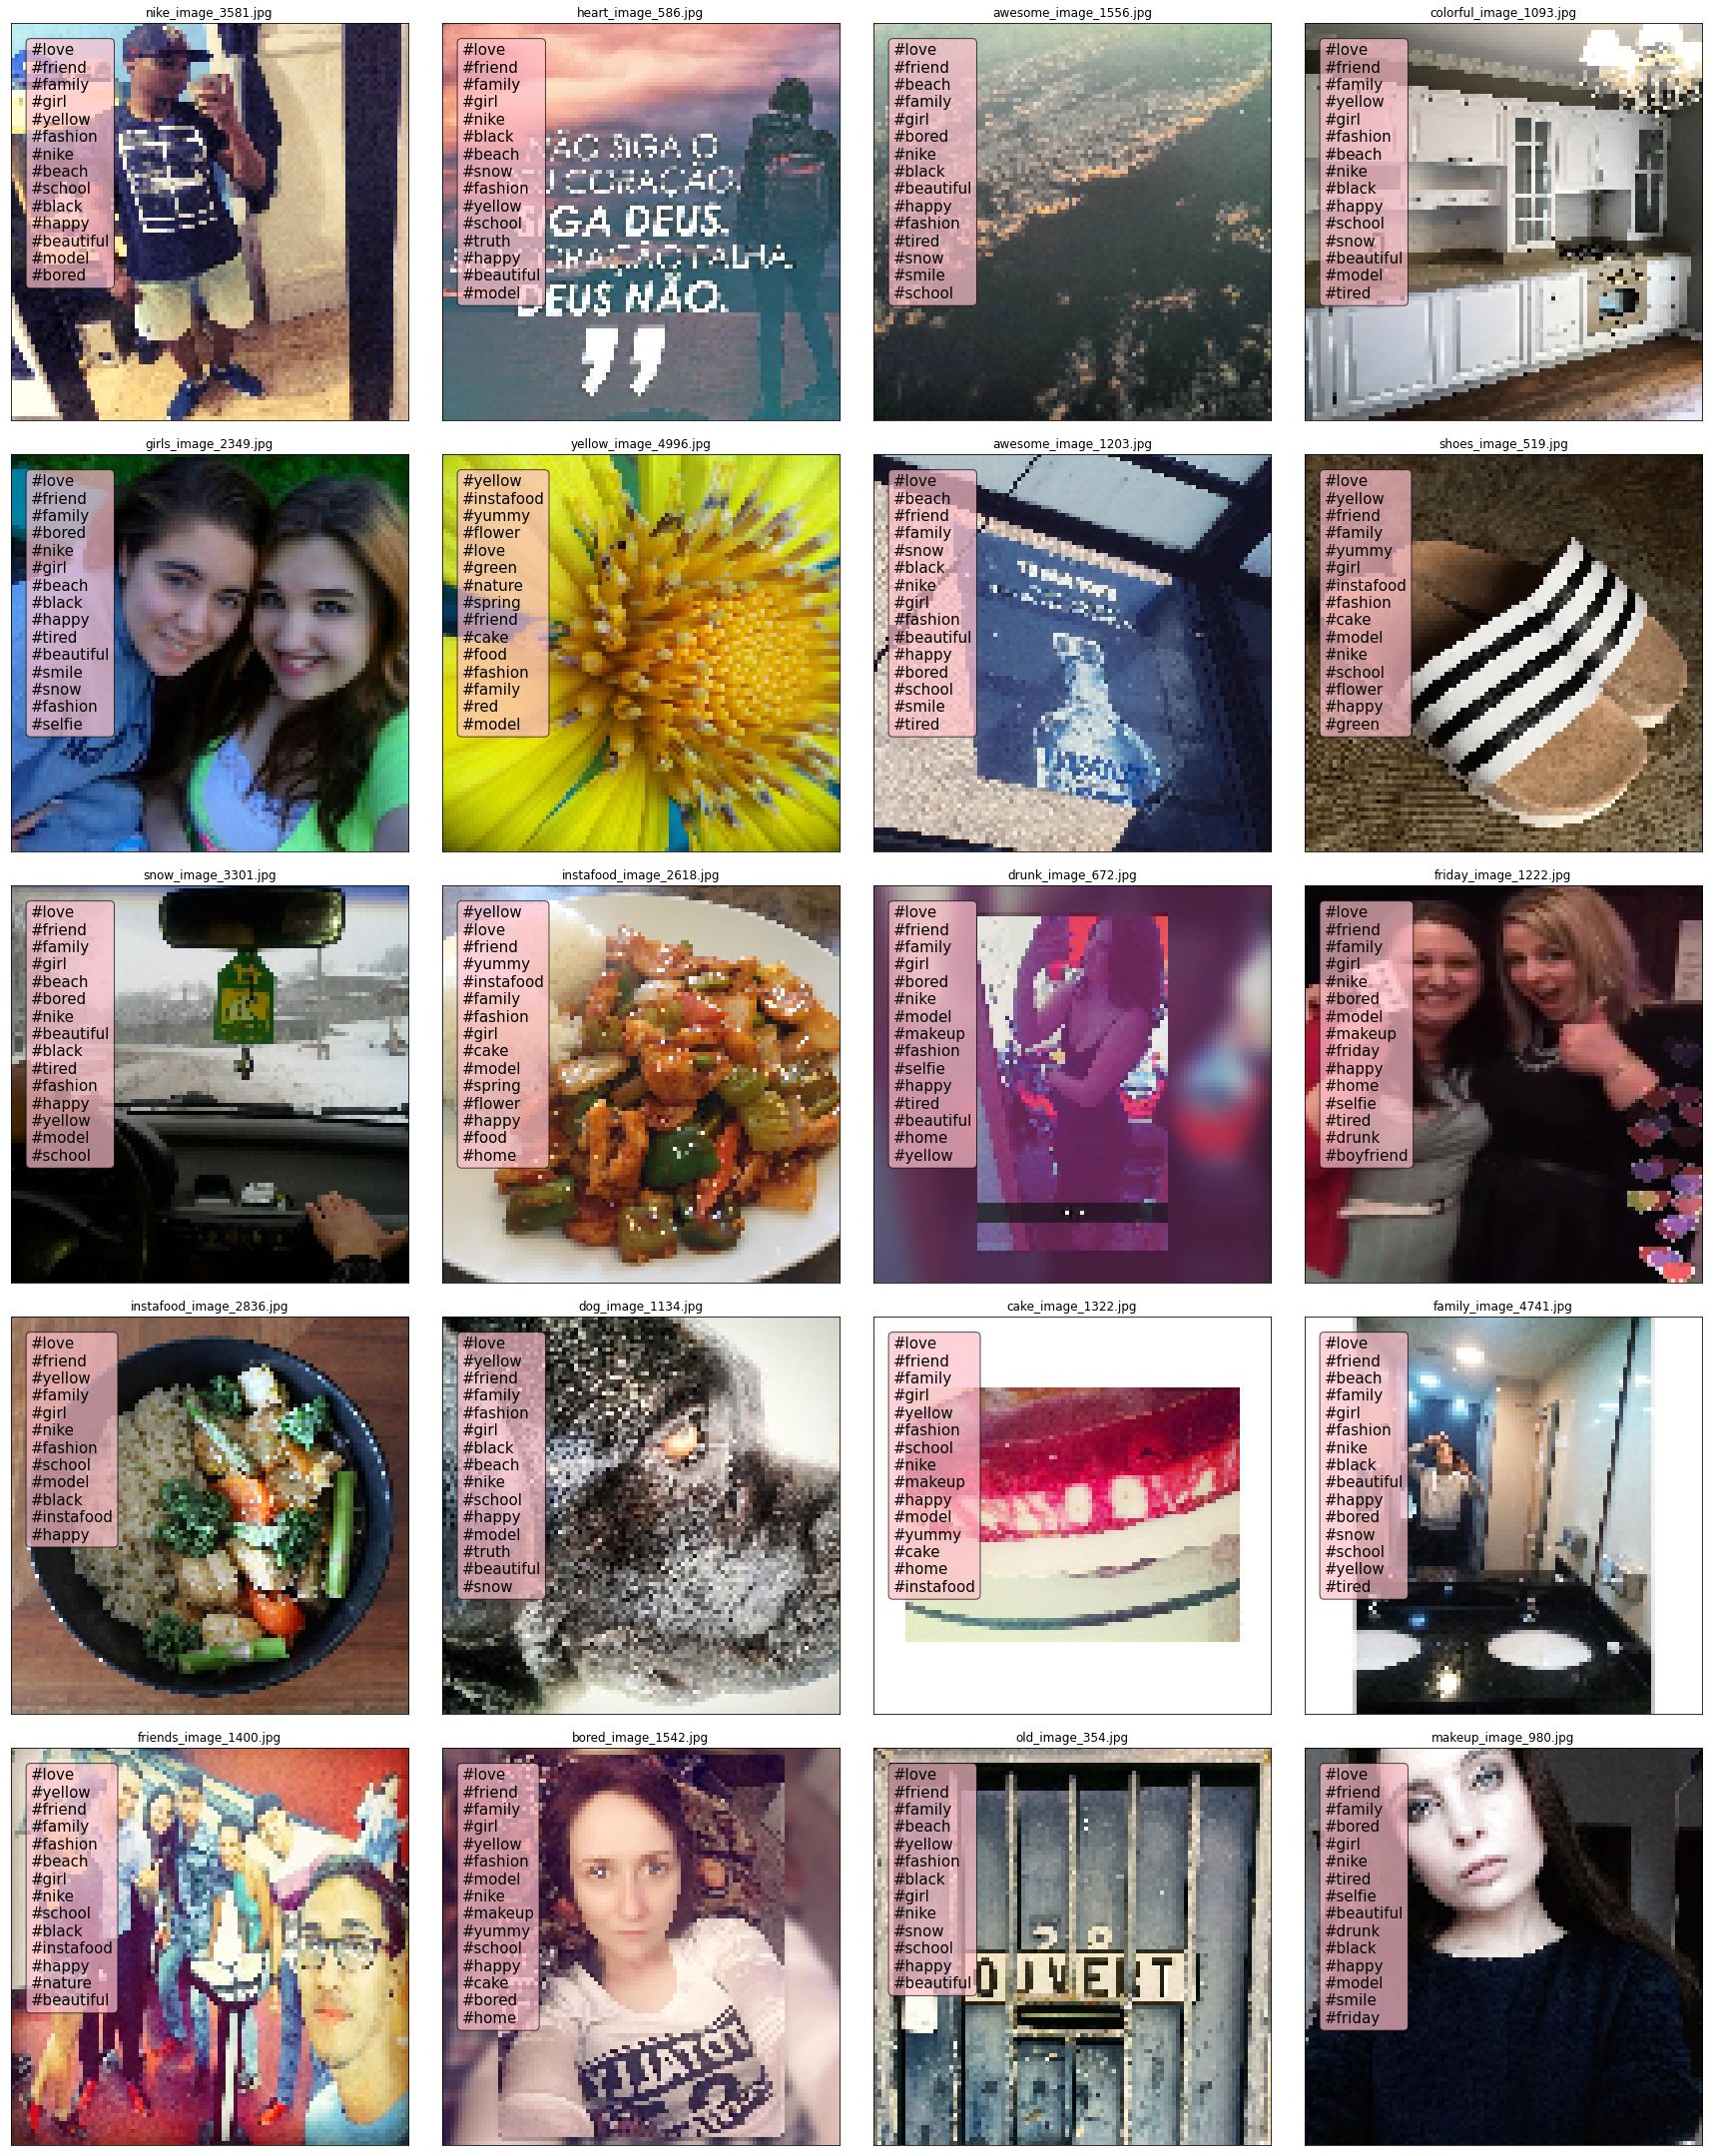

In [12]:
top10 = results["y_pred"].apply(lambda x: x[:15])
show_images(test_generator, data_list=results.filename, tag_list=top10, categorical=False)

## Reference
https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24